In [1]:
#@title # Agregando Drive a Colab
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Artificial Intelligence II/IA 2 2020-1 Proyecto Final'
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/17YrASDZ5pWWdovHc-kTvcHMAq0-oe7t_/Artificial Intelligence II/IA 2 2020-1 Proyecto Final
/content/drive/.shortcut-targets-by-id/17YrASDZ5pWWdovHc-kTvcHMAq0-oe7t_/Artificial Intelligence II/IA 2 2020-1 Proyecto Final


In [2]:
#@title # Importando librerías
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from IPython.display import Image
from IPython.display import clear_output

import urllib.request
from PIL import Image

from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# **Proyecto: Restauración de Imagenes Borrosas aplicando Transferencia de Aprendizaje**

**Integrantes**

*   Emmanuel David Martínez Estrada
*   María Paula Riveros Gómez


## **Motivación**

Actualmente existe una gran cantidad de información, en dónde parte de estos datos consisten en imágenes. Es común que las personas tomen muchas fotografias en las cuales, debido a factores externos, estas terminan viendose borrosas.
Se propone recopilar un pequeño dataset de imágenes borrosas con el propósito de corregirlas mediante el uso de una red neuronal aplicando una técnica denominada Transferencia de Aprendizaje.


## **Objetivos**

*   Restaurar imagenes borrosas.
*   Motivar el uso de transferencia de aprendizaje para la restauración de imagenes.
*  Comparar diferentes CNNs contra la CNN propuesta.

## **Datasets**

Los datasets que se usarán para este proyecto serán dos:

1. Open images v6 desarrollado por Google es un conjunto de datos de ~ 9 millones de imágenes anotadas con etiquetas a nivel de imagen, cuadros delimitadores de objetos, máscaras de segmentación de objetos, relaciones visuales y narrativas localizadas.

  **Para este proyecto solo se tomaron 2000 imagenes limpias, es decir sin modificaciones ni etiquetas.**

<img src="https://i.ibb.co/5xJcJ7h/OIDv6.png">

  **Fuente:** https://storage.googleapis.com/openimages/web/index.html

2. Blur dataset es conjunto de datos que contiene 1050 imágenes borrosas y nítidas (350 tripletes), cada triplete de imágenes es un conjunto de tres fotos de la misma escena: imágenes nítidas, desenfocadas-borrosas y movidas por movimiento. Este dataset fue creado para un algoritmo de detección de desenfoque, por lo que las tripletas de imagenes no son pixel a pixel, esto significa que las imagenes no exactamente iguales, lo cual añade complejidad al problema que se quiere resolver.

  **Para este proyecto solo se tomaron los pares de imagenes desenfocadas-borrosas con sus respectivas imagenes nitidas.**

<center><img src="https://i.ibb.co/3cst5ZT/Blur-Dataset.png"><center>

  **Fuente:** https://www.kaggle.com/kwentar/blur-dataset

  ### **Información de los datasets detallada:**

<center><img src="https://i.ibb.co/s5n4Qf2/datasets.png" width="50%"></center>
  

In [3]:
#@title ## Función para construir el dataset
def build_dataset_table(input_path, target_path):
  input = sorted(os.listdir(input_path))
  target = sorted(os.listdir(target_path))

  input = [input_path + filename for filename in input]
  target = [target_path + filename for filename in target]

  dataset = np.array([input, target]).T

  return dataset

In [ ]:
#@title # **Construyendo Open Images v6 dataset**
OIDV6_path = 'OIDataset/OIDataset/'

OIDV6_dataset = build_dataset_table(OIDV6_path, OIDV6_path)
print(OIDV6_dataset.shape)
OIDV6_dataset[:5,:]

(2000, 2)


array([['OIDataset/OIDataset/image1.png',
        'OIDataset/OIDataset/image1.png'],
       ['OIDataset/OIDataset/image10.png',
        'OIDataset/OIDataset/image10.png'],
       ['OIDataset/OIDataset/image100.png',
        'OIDataset/OIDataset/image100.png'],
       ['OIDataset/OIDataset/image1000.png',
        'OIDataset/OIDataset/image1000.png'],
       ['OIDataset/OIDataset/image1001.png',
        'OIDataset/OIDataset/image1001.png']], dtype='<U33')

In [4]:
#@title funcion para cargar las imagenes de entrada y salida para la CNN
img_width = 512
img_height = 512

def load_image(image_filename):
  
  im_inp = Image.open(image_filename[0])
  im_inp = np.array(im_inp.resize((img_width,img_height)))
  im_inp = im_inp/np.max(im_inp)
  
  im_tar = Image.open(image_filename[1])
  im_tar = np.array(im_tar.resize((img_width,img_height)))
  im_tar = im_tar/np.max(im_tar)

  return im_inp, im_tar


In [5]:
#@title Función para graficar imagenes input con su respectivo target
def plot_images(input, target):
  
  plt.figure(figsize=(15, 15))
  plt.subplot(121)
  plt.imshow(input)
  plt.title('Input image')
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(target)
  plt.title('Target image')
  plt.axis('off')

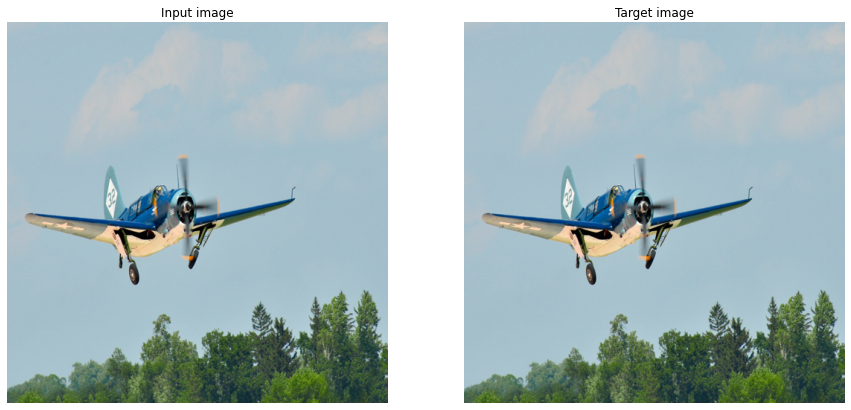

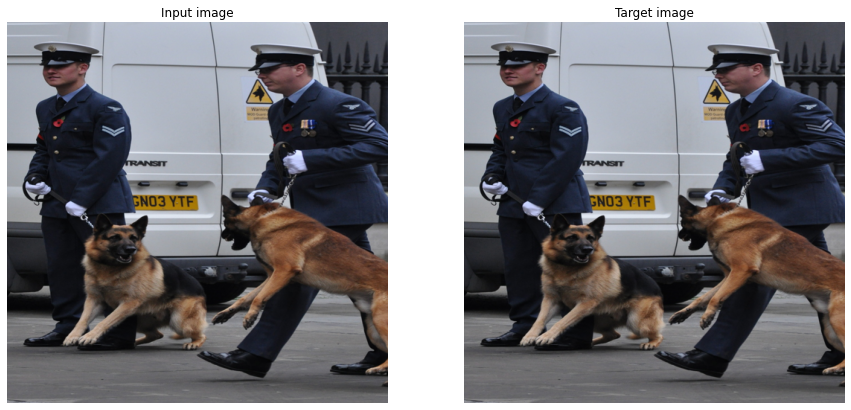

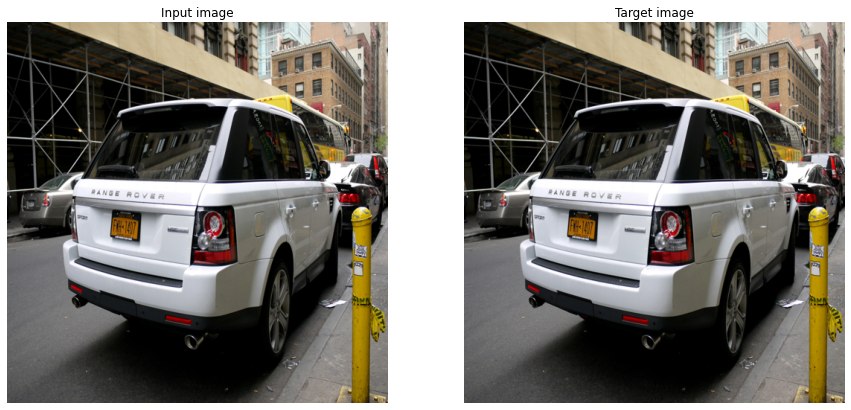

In [ ]:
#@title Mostrando imagenes de los datasets
for i in range(3):
  input, target = load_image(OIDV6_dataset[i,:])
  plot_images(input, target)

In [6]:
#@title # **Construyendo Blur Dataset**
blur_path = 'BlurDataset/defocused_blurred/'
sharp_path = 'BlurDataset/sharp/'

blur_dataset = build_dataset_table(blur_path, sharp_path)
blur_dataset[:5,:]

array([['BlurDataset/defocused_blurred/0_IPHONE-SE_F.JPG',
        'BlurDataset/sharp/0_IPHONE-SE_S.JPG'],
       ['BlurDataset/defocused_blurred/100_NIKON-D3400-35MM_F.JPG',
        'BlurDataset/sharp/100_NIKON-D3400-35MM_S.JPG'],
       ['BlurDataset/defocused_blurred/101_NIKON-D3400-35MM_F.JPG',
        'BlurDataset/sharp/101_NIKON-D3400-35MM_S.JPG'],
       ['BlurDataset/defocused_blurred/102_NIKON-D3400-35MM_F.JPG',
        'BlurDataset/sharp/102_NIKON-D3400-35MM_S.JPG'],
       ['BlurDataset/defocused_blurred/103_HUAWEI-P20_F.jpg',
        'BlurDataset/sharp/103_HUAWEI-P20_S.jpg']], dtype='<U71')

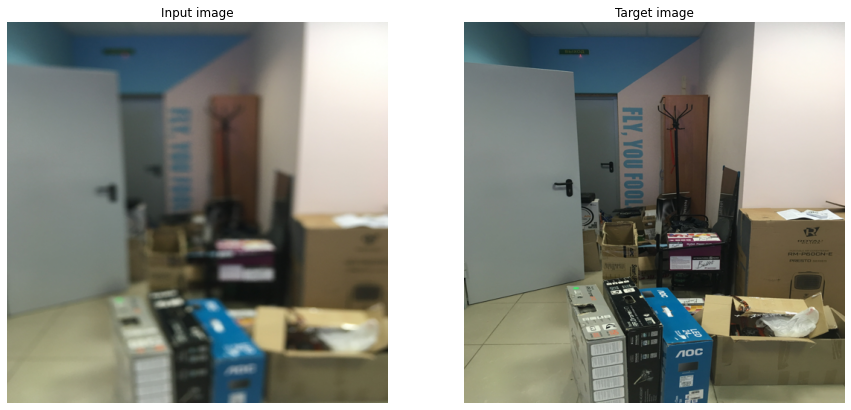

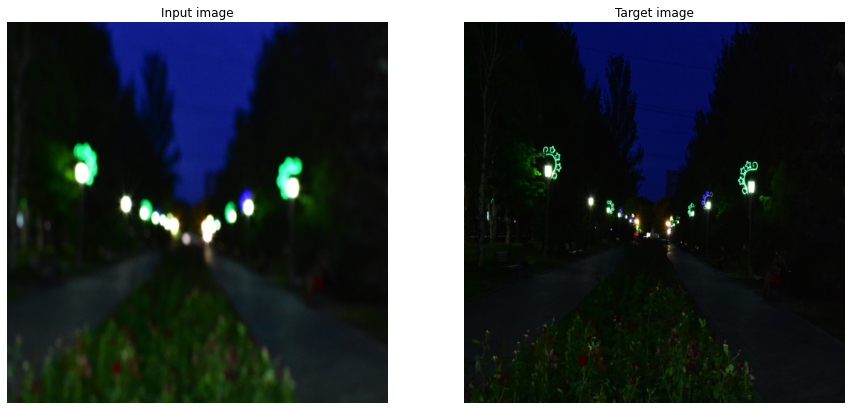

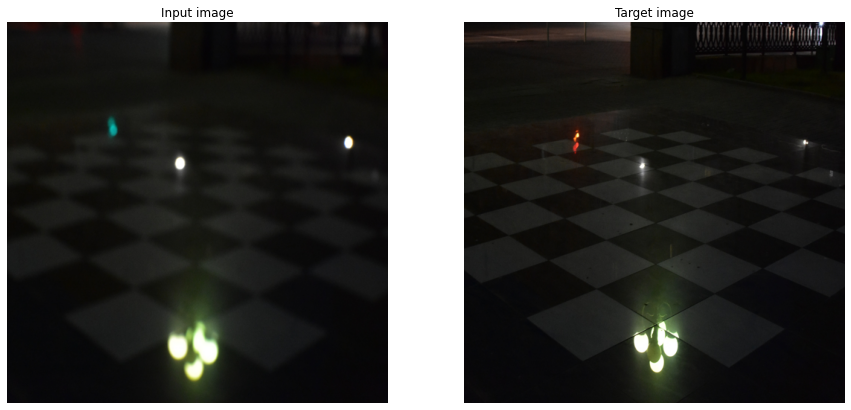

In [7]:
#@title Mostrando imagenes del dataset de imagenes borrosas
for i in range(3):
  input, target = load_image(blur_dataset[i,:])
  plot_images(input, target)

In [8]:
#@title # **Generador del dataset** (para evitar saturar la memoria RAM que posee Colab)
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'

  def __init__(self, image_list, batch_size=1, image_size=(512, 512, 3), shuffle=True):
    'Initialization'
    self.image_list = image_list
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.image_list) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    # Find list of IDs
    image_list_temp = [self.image_list[k,:] for k in indexes]

    # Generate data
    input_data, output_data = self.__data_generation(image_list_temp)

    return input_data, output_data

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.image_list))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, image_list_temp):
    'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
    # Initialization
    input_data = np.empty((self.batch_size, *self.image_size))
    output_data = np.empty((self.batch_size, *self.image_size))

    # Generate data
    for i, images_filename in enumerate(image_list_temp):
      # Store input and output
      input_data[i,...], output_data[i,] = load_image(images_filename)

    return input_data, output_data
    

In [9]:
#@title Función para construir los datasets
def build_dataset(dataset, batch_size, img_width, img_height, split_data=.8):
  params = {'batch_size': batch_size,
            'image_size': (img_width, img_height, 3),
            'shuffle': False}

  n = int(split_data * dataset.shape[0])
  # Datasets
  if isinstance(dataset, np.ndarray):
    train_filenames = dataset[:n,:]
    test_filenames = dataset[n:,:]
  else:
    print("'dataset' must be a numpy list")
    return -1

  # Generators
  train_generator = DataGenerator(train_filenames, **params)
  test_generator = DataGenerator(test_filenames, **params)

  train_dataset = tf.data.Dataset.from_generator(lambda:train_generator, (tf.float32, tf.float32),
      (tf.TensorShape([None, img_width, img_height, 3]), tf.TensorShape([None, img_width, img_height, 3])))

  test_dataset = tf.data.Dataset.from_generator(lambda: test_generator, (tf.float32, tf.float32),
      (tf.TensorShape([None, img_width, img_height, 3]), tf.TensorShape([None, img_width, img_height, 3])))
  
  return train_dataset, test_dataset


In [ ]:
#@title Construyendo los datasets de Open Images v6 para tensorflow
batch_size = 1
split_data = .8
OIDV6_train_dataset, OIDV6_test_dataset = build_dataset(OIDV6_dataset, batch_size, img_width, img_height, split_data=split_data)
print('Train dataset: {}'.format(OIDV6_train_dataset))
print('Test dataset: {}'.format(OIDV6_test_dataset))

Train dataset: <FlatMapDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>
Test dataset: <FlatMapDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>


In [10]:
#@title Construyendo los datasets de Blur_dataset para tensorflow
batch_size = 1
split_data = .8
blur_train_dataset, blur_test_dataset = build_dataset(blur_dataset, batch_size, img_width, img_height, split_data=split_data)
print('Train dataset: {}'.format(blur_train_dataset))
print('Test dataset: {}'.format(blur_test_dataset))

Train dataset: <FlatMapDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>
Test dataset: <FlatMapDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>


## **CNN propuesta**

Para resolver este problemas usaremos una arquitectura de autoencoder basada en U-Net, ya que esta arquitectura tiene las siguientes bondades:

1. Reconstrucción de una imagen (objetivo) a partir de otra imagen (entrada).
2. Ha mostrado buenos resultados en el estado del arte, especialmente en cuanto a la segmentación de objetos en imagenes.

La arquitectura usada especificamente es la siguiente:

<img src="https://i.ibb.co/Rj64DNd/U-net-propuesta.png" style="width:100%">

La arquitectura se compone de los siguientes bloques:

* **Bloque de Double Conv2D:** estos bloques contribuyen al mapeo del características más relevantes del dataset de entrenamiento, constan de una convolución $3 \times 3$ seguida de una activación ReLU y un Dropout en $10\%$ a $20\%$ de desconexiones, luego se repite otra convolución $3 \times 3$ con su respectiva activación ReLU.

* **Bloque Downsample:** contiene un capa de max-pooling $2 \times 2$, permite reducir espacialmente el tamaño del mapa del caracteristicas.

* **Bloque Upsample:** contiene un capa de convolución inversa $3 \times 3$, permite aumentar la muestra del mapa de características de entrada a un mapa de características de salida deseado.

## **Hiperparametros**

Los hiperparametros usados para este modelo y todas las pruebas realizadas (modelos de comparación) son:

*  Optimizador Adam con una tasa de aprendizaje de $1 \times 10^{-3}$
*  100 épocas o iteraciones


## **Métricas de evaluación**

Las métricas usadas para evaluar la calidad de la reconstrucción serán:

*  Proporción Máxima de Señal a Ruido (PSNR):

  $$PSNR = 10\log_{10}\frac{||I_n||_{\infty}NM}{||I_e-I_n||^{2}_{F}}$$

* Error Cuadratico Medio (MSE):

  $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(I_n^i-I_e^i)^2}$$

Donde en ambas ecuaciones se compara cada imagen objetivo con su reconstrucción pixel a pixel.



## **Aprendiendo pesos optimos**

Como nuestro dataset para la restauración de imagenes solo contiene 350 pares de imagenes borrosas con su respectiva imagen en optimas condiciones, lo más probable es que si solo realizamos el entrenamiento de la CNN propuesta con esta cantidad de imagenes se genere sobre-ajuste (overfitting), esto significa, que el modelo quedaría sobre entrenado ya que como solo recibe un pequeño conjunto de imagenes de entrenamiento para aprender sus pesos, cuando se prueben las imagenes no será de realizar una buena aproximación en la reconstrucción debido a la cantidad de imagenes entrenadas.

Por lo tanto, para aprender pesos optimos nuestro modelo vamos a aplicar transferencia de aprendizaje que permite mitigar los problemas mencionados anteriormente, para ello primero entrenaremos nuestro modelo con el dataset Open Images v6 donde realizaremos una reconstrucción de RGB a RGB, esto permitirá generalizar mucho mejor el mapeo de caracteristicas de las imagenes en el dataset.

In [11]:
#@title Definiendo el modelo
def crear_modelo(batch_size=1, input_size=(512, 512, 3)):
  
  # Down
  inputs = Input(name='input', shape=input_size, batch_size=batch_size)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(3, 1, activation='sigmoid')(c9)
  
  return Model(inputs=inputs, outputs=outputs)

In [12]:
#@title Métrica de PSNR para evaluar la calidad de reconstrucción
def psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [13]:
#@title creando el modelo propuesto (aprendiendo sus pesos optimos)
# model.reset -> buscar
model = crear_modelo()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False),
              loss='mean_squared_error',
              metrics=['accuracy', psnr])

## **Vista del modelo cuando se aprenden los pesos óptimos**

Como en el primer entrenamiento para aprender los pesos óptimos solo se entrena el dataset de imagenes RGB a RGB, como este dataset es supremamente extenso solo tomamos 2000 imagenes para realiza realizar esta parte del proceso, lo que se hizo fue generar pares de imagenes donde la imagen de entrada con su respectiva imagen de salida son iguales, esto es lo que formalmente se le conocería como un proceso básico de autoencoder.

<center><img src="https://i.ibb.co/mNh7HRY/U-net-propuesta-start.png" width="80%"></center>

En la figura observamos una de las imagenes del dataset que pasan a través del bloque **Proposed Model** que simplemente representa el modelo propuesto y finalmente retorna la imagen reconstruida que sería ella misma.




In [17]:
#@title Graficando reconstrucción de imagen (entrada, reconstrucción, objetivo)
def plot_image_pair_reconstructed(input, reconstructed, target):
  plt.figure(figsize=(16, 8))
  plt.subplot(131)
  plt.imshow(input)
  plt.title('Input')
  plt.axis('off')
  plt.subplot(132)
  plt.imshow(reconstructed)
  plt.title('Reconstructed')
  plt.axis('off')
  plt.subplot(133)
  plt.imshow(target)
  plt.title('Ground Truth')
  plt.axis('off')
  print('PSNR obtenido:', psnr(input[tf.newaxis,...], reconstructed[tf.newaxis,...]))

PSNR obtenido: tf.Tensor([8.77665], shape=(1,), dtype=float32)


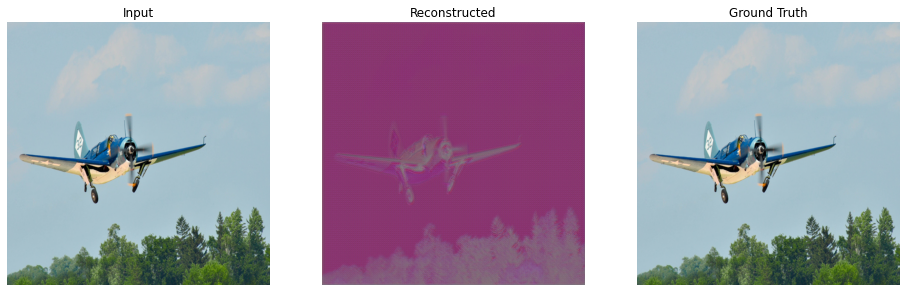

In [ ]:
#@title Reconstruyendo imagen sin haber entrenado el modelo
image_path = OIDV6_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

In [ ]:
#@title Checkpoint
checkpoint_dir = "Check_points_Transfer_Learning_36_1"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=model)

In [ ]:
#@title (Ejecutar esta celda solo para cargar el modelo y su historial de entrenamiento)
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title Guardar modelo
# checkpoint.save(file_prefix = checkpoint_prefix)
# np.save('Histories/10_epochs.npy', history.history)

In [ ]:
#@title Entrenando el modelo
TOTAL_EPOCHS = 100
SAVE_EPOCHS = 20
PSNR_grap = []
LOSS_grap = []
accuracy_grap = []
for i in range(int(TOTAL_EPOCHS/SAVE_EPOCHS)):
  print("Iteración {}".format(i + 1))
  history = model.fit(OIDV6_train_dataset, epochs=SAVE_EPOCHS,verbose=1)
  PSNR_grap.append(history.history['psnr'])
  LOSS_grap.append(history.history['loss'])
  accuracy_grap.append(history.history['accuracy'])
  checkpoint.save(file_prefix=checkpoint_prefix)
  np.save(checkpoint_dir+"/PSNR.npy", PSNR_grap)
  np.save(checkpoint_dir+"/LOSS.npy", LOSS_grap)
  np.save(checkpoint_dir+"/ACCU.npy", accuracy_grap)

Iteración 1
Epoch 1/20
1600/1600 [==============================] - 99s 62ms/step - loss: 0.0058 - accuracy: 0.7127 - psnr: 25.4050
Epoch 2/20
1600/1600 [==============================] - 99s 62ms/step - loss: 0.0016 - accuracy: 0.7947 - psnr: 28.5848
Epoch 3/20
1600/1600 [==============================] - 99s 62ms/step - loss: 0.0013 - accuracy: 0.8019 - psnr: 29.5427
Epoch 4/20
1600/1600 [==============================] - 99s 62ms/step - loss: 0.0011 - accuracy: 0.8067 - psnr: 30.0878
Epoch 5/20
1600/1600 [==============================] - 99s 62ms/step - loss: 9.9321e-04 - accuracy: 0.8080 - psnr: 30.5434
Epoch 6/20
1600/1600 [==============================] - 99s 62ms/step - loss: 8.8764e-04 - accuracy: 0.8157 - psnr: 31.0023
Epoch 7/20
1600/1600 [==============================] - 98s 61ms/step - loss: 8.4890e-04 - accuracy: 0.8184 - psnr: 31.2155
Epoch 8/20
1600/1600 [==============================] - 99s 62ms/step - loss: 7.9651e-04 - accuracy: 0.8236 - psnr: 31.5506
Epoch 9/20
1

PSNR obtenido: tf.Tensor([22.999683], shape=(1,), dtype=float32)


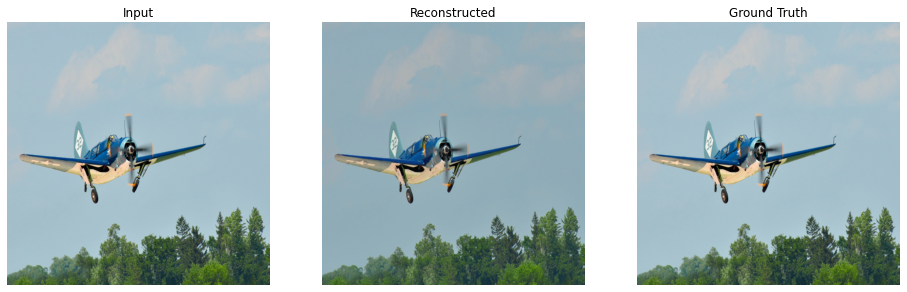

In [ ]:
#@title Probando el modelo con la misma imagen después de entrenar el modelo
image_path = OIDV6_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

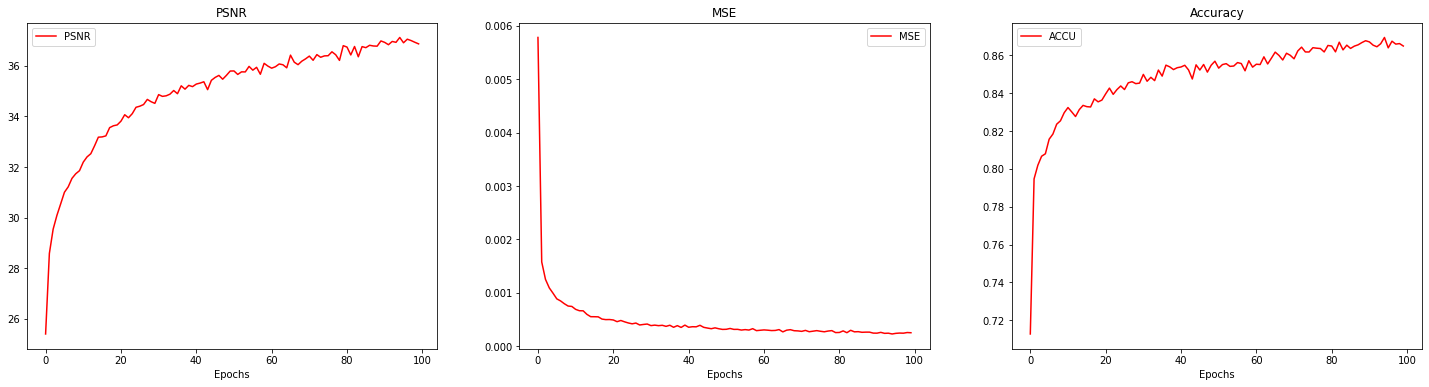

In [ ]:
#@title Convergencia del modelo con las diferentes métricas establecidas
_psnr_init_model = np.load(checkpoint_dir + '/PSNR.npy').reshape((-1,1)).squeeze()
_loss_init_model = np.load(checkpoint_dir + '/LOSS.npy').reshape((-1,1)).squeeze()
_accu_init_model = np.load(checkpoint_dir + '/ACCU.npy').reshape((-1,1)).squeeze()

epochs=range(len(_psnr_init_model))

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.plot(epochs, _psnr_init_model, 'red', label='PSNR')
plt.title('PSNR')
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,3,2)
plt.plot(epochs, _loss_init_model, 'red', label='MSE')
plt.title('MSE')
plt.xlabel("Epochs")
plt.legend();

plt.subplot(1,3,3)
plt.plot(epochs, _accu_init_model, 'red', label='ACCU')
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.legend();

In [ ]:
#@title Visualizando reconstrucciones
PSNR = []
for i, (test_input, test_output) in enumerate(OIDV6_test_dataset.take(70)):
  reconstructed = model(test_input, training=False)
  metrica = psnr(test_output, reconstructed)
  if i < 7:
    gen_img_rgb = np.array(reconstructed[0,...])
    plot_image_pair_reconstructed(test_input[0,...],
                                  reconstructed[0,...],
                                  test_output[0,...])
  PSNR.append(metrica)
  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title PSNR de todas las imagenes de entrenamiento
PSNR

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.700119], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.031633], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.167437], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.633898], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([27.973942], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([26.08111], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([31.588892], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([24.108177], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([27.161875], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([28.591055], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([30.70343], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([27.095745], dtype=float32)>,
 <tf.Tensor: shape

In [ ]:
#@title Media del PNSR de todas las imagenes de entrenamiento
PSNR_mean = tf.math.reduce_mean(np.array(PSNR))
PSNR_mean

<tf.Tensor: shape=(), dtype=float32, numpy=25.74806>

## **Aplicando ajuste fino (Fine tuning)**

El ajuste fino es parte de la estrategia de transferencia de aprendizaje, consiste en tomar pesos de una red neuronal entrenada y usarla como inicialización para un nuevo modelo que se está entrenando con datos del mismo dominio.

Como se mencionó inicialmente, esta técnica permite:

*  Evitar el sobreajuste que se puede generar debido a la poca cantidad de imagenes con las que contamos.
*  Acelerar el entrenamiento.


## **Vista del modelo congelando solo la mitad de los pesos**

Para este modelo congelaremos la mitad de sus pesos (encoder) ya que esta parte del modelo es la que aprende la parte más importante del mapeo de caracteristicas de las imagenes que recibe como lo son sus patrones más elementales que son lineas, curvas, y formas geometricas simples como cuadrados o circulos.

<center><img src="https://i.ibb.co/xLg16S7/U-net-propuesta-part2.png" width="100%"></center>



In [14]:
transfer_model = tf.keras.models.clone_model(model)
for i, layer in enumerate(transfer_model.layers[:18]):
  layer.trainable = False

transfer_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 512, 512, 16)    448         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (1, 512, 512, 16)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (1, 512, 512, 16)    2320        dropout[0][0]                    
_______________________________________________________________________________________

In [15]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False),
                       loss='mean_squared_error',
                       metrics=['accuracy', psnr])

PSNR obtenido: tf.Tensor([12.522829], shape=(1,), dtype=float32)


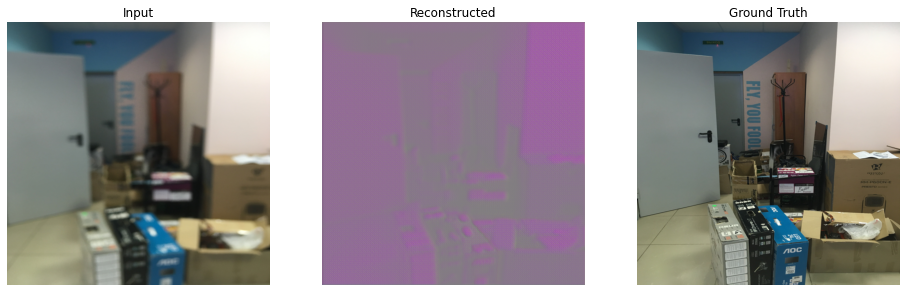

In [18]:
#@title Reconstruyendo imagen con los pesos pre-entrenados
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = transfer_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

In [19]:
#@title Checkpoint
checkpoint_dir = "Check_points_Transfer_Learning_Blur_36_1"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=transfer_model)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title Guardar modelo
# checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
#@title Entrenando el modelo
TOTAL_EPOCHS = 100
SAVE_EPOCHS = 20
PSNR_grap = []
LOSS_grap = []
accuracy_grap = []
for i in range(int(TOTAL_EPOCHS/SAVE_EPOCHS)):
  print("Iteración {}".format(i + 1))
  history = transfer_model.fit(blur_train_dataset, epochs=SAVE_EPOCHS,verbose=1)
  PSNR_grap.append(history.history['psnr'])
  LOSS_grap.append(history.history['loss'])
  accuracy_grap.append(history.history['accuracy'])
  checkpoint.save(file_prefix=checkpoint_prefix)
  np.save(checkpoint_dir+"/PSNR.npy", PSNR_grap)
  np.save(checkpoint_dir+"/LOSS.npy", LOSS_grap)
  np.save(checkpoint_dir+"/ACCU.npy", accuracy_grap)

Iteración 1
Epoch 1/20
280/280 [==============================] - 225s 805ms/step - loss: 0.0564 - accuracy: 0.4842 - psnr: 13.1055
Epoch 2/20
280/280 [==============================] - 77s 274ms/step - loss: 0.0410 - accuracy: 0.5465 - psnr: 14.3779
Epoch 3/20
280/280 [==============================] - 78s 278ms/step - loss: 0.0397 - accuracy: 0.5755 - psnr: 14.5629
Epoch 4/20
280/280 [==============================] - 76s 273ms/step - loss: 0.0390 - accuracy: 0.5935 - psnr: 14.6582
Epoch 5/20
280/280 [==============================] - 76s 272ms/step - loss: 0.0393 - accuracy: 0.6062 - psnr: 14.6958
Epoch 6/20
280/280 [==============================] - 77s 274ms/step - loss: 0.0387 - accuracy: 0.6109 - psnr: 14.7123
Epoch 7/20
280/280 [==============================] - 77s 275ms/step - loss: 0.0381 - accuracy: 0.6195 - psnr: 14.7938
Epoch 8/20
280/280 [==============================] - 79s 284ms/step - loss: 0.0379 - accuracy: 0.6235 - psnr: 14.8090
Epoch 9/20
280/280 [===============

PSNR obtenido: tf.Tensor([20.353065], shape=(1,), dtype=float32)


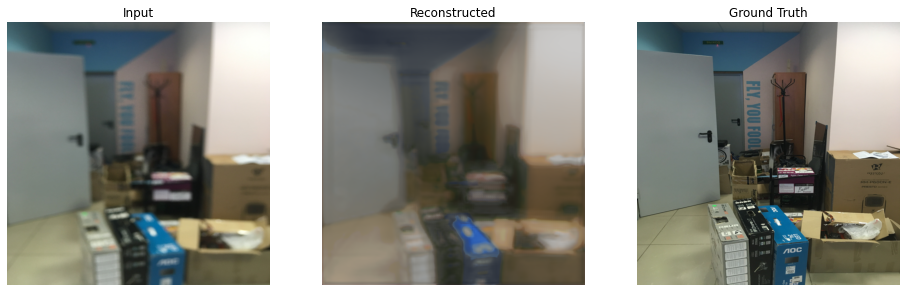

In [20]:
#@title Probando el modelo con la misma imagen después de entrenar el modelo
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = transfer_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

# **Modelos entrenados para comparar contra el modelo propuesto**

Se desarrollaron 3 modelos más para comparar contra nuestro modelo propuesto, estos modelos son:

*  Modelo preentrenado sin congelamiento de capas.
*  Modelo sin transferencia de aprendizaje.
*  Modelo Xception modificado para realizar la tarea de autoencoder.

## **Modelo preentrenado sin congelamiento de capas**

El modelo se conserva igual que el primero presentado solo que con los pesos preentrenados de la primera parte de este notebook, lo único que cambia es el dataset.

<center><img src="https://i.ibb.co/1Lbm8FH/U-net-propuesta-part1.png" width="80%"></center>


In [21]:
transfer_model_no_freezing = tf.keras.models.clone_model(model)
transfer_model_no_freezing.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 512, 512, 16)    448         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (1, 512, 512, 16)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (1, 512, 512, 16)    2320        dropout[0][0]                    
_______________________________________________________________________________________

In [22]:
transfer_model_no_freezing.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False),
                                   loss='mean_squared_error',
                                   metrics=['accuracy', psnr])

PSNR obtenido: tf.Tensor([11.65158], shape=(1,), dtype=float32)


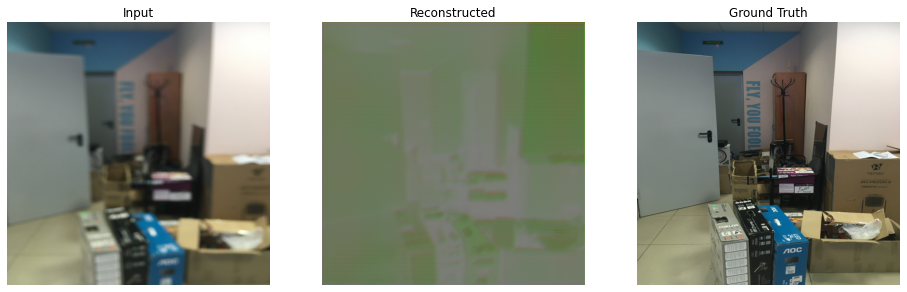

In [23]:
#@title Reconstruyendo imagen con los pesos pre-entrenados
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = transfer_model_no_freezing(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

In [25]:
#@title Checkpoint
checkpoint_dir = "Check_points_Transfer_Learning_NO_Freezing"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=transfer_model_no_freezing)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title Guardar modelo
# checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
#@title Entrenando el modelo
TOTAL_EPOCHS = 100
SAVE_EPOCHS = 20
PSNR_grap = []
LOSS_grap = []
accuracy_grap = []
for i in range(int(TOTAL_EPOCHS/SAVE_EPOCHS)):
  print("Iteración {}".format(i + 1))
  history = transfer_model_no_freezing.fit(blur_train_dataset, epochs=SAVE_EPOCHS,verbose=1)
  PSNR_grap.append(history.history['psnr'])
  LOSS_grap.append(history.history['loss'])
  accuracy_grap.append(history.history['accuracy'])
  checkpoint.save(file_prefix=checkpoint_prefix)
  np.save(checkpoint_dir+"/PSNR.npy", PSNR_grap)
  np.save(checkpoint_dir+"/LOSS.npy", LOSS_grap)
  np.save(checkpoint_dir+"/ACCU.npy", accuracy_grap)

Iteración 1
Epoch 1/20
280/280 [==============================] - 84s 301ms/step - loss: 0.0497 - accuracy: 0.5580 - psnr: 13.6095
Epoch 2/20
280/280 [==============================] - 84s 301ms/step - loss: 0.0400 - accuracy: 0.6299 - psnr: 14.5096
Epoch 3/20
280/280 [==============================] - 84s 301ms/step - loss: 0.0386 - accuracy: 0.6226 - psnr: 14.7004
Epoch 4/20
280/280 [==============================] - 84s 299ms/step - loss: 0.0377 - accuracy: 0.6265 - psnr: 14.8268
Epoch 5/20
280/280 [==============================] - 84s 300ms/step - loss: 0.0370 - accuracy: 0.6361 - psnr: 14.9402
Epoch 6/20
280/280 [==============================] - 84s 301ms/step - loss: 0.0364 - accuracy: 0.6455 - psnr: 15.0098
Epoch 7/20
280/280 [==============================] - 84s 299ms/step - loss: 0.0361 - accuracy: 0.6455 - psnr: 15.0574
Epoch 8/20
280/280 [==============================] - 84s 299ms/step - loss: 0.0356 - accuracy: 0.6448 - psnr: 15.1293
Epoch 9/20
280/280 [================

PSNR obtenido: tf.Tensor([19.352743], shape=(1,), dtype=float32)


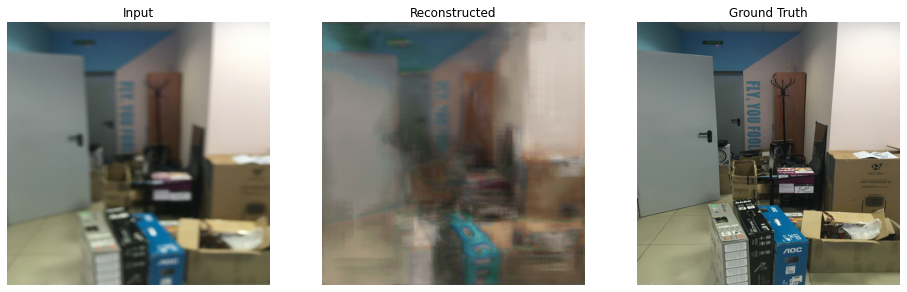

In [26]:
#@title Probando el modelo con la misma imagen después de entrenar el modelo
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = transfer_model_no_freezing(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

## **Modelo sin transferencia de aprendizaje**

Este modelo es una comparación directa de las ventajas que ofrece aplicar transferencia de aprendizaje para comparar la calidad de la reconstrucción, por lo que el esquema propuesto se mantiene, solo que ahora sus pesos serán inicializados aleatoriamente.

<center><img src="https://i.ibb.co/0DV47zs/U-net-propuesta-part3.png" width="80%"></center>

In [27]:
no_transfer_model = crear_modelo()
no_transfer_model.summary()
no_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False),
              loss='mean_squared_error',
              metrics=['accuracy', psnr])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (1, 512, 512, 16)    448         input[0][0]                      
__________________________________________________________________________________________________
dropout_9 (Dropout)             (1, 512, 512, 16)    0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (1, 512, 512, 16)    2320        dropout_9[0][0]                  
_______________________________________________________________________________________

PSNR obtenido: tf.Tensor([11.770574], shape=(1,), dtype=float32)


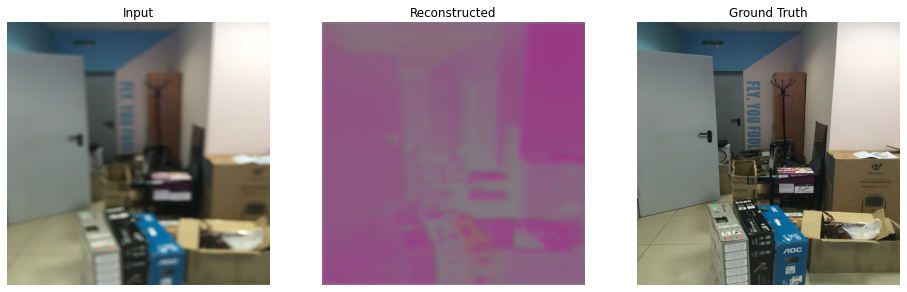

In [28]:
#@title Reconstruyendo imagen con pesos aleatorios
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = no_transfer_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

In [30]:
#@title Checkpoint
checkpoint_dir = "Check_points_NO_Transfer_Learning_Blur"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=no_transfer_model)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title Guardar modelo
# checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
#@title Entrenando el modelo
TOTAL_EPOCHS = 100
SAVE_EPOCHS = 20
PSNR_grap = []
LOSS_grap = []
accuracy_grap = []
for i in range(int(TOTAL_EPOCHS/SAVE_EPOCHS)):
  print("Iteración {}".format(i + 1))
  history = no_transfer_model.fit(blur_train_dataset, epochs=SAVE_EPOCHS,verbose=1)
  PSNR_grap.append(history.history['psnr'])
  LOSS_grap.append(history.history['loss'])
  accuracy_grap.append(history.history['accuracy'])
  checkpoint.save(file_prefix=checkpoint_prefix)
  np.save(checkpoint_dir+"/PSNR.npy", PSNR_grap)
  np.save(checkpoint_dir+"/LOSS.npy", LOSS_grap)
  np.save(checkpoint_dir+"/ACCU.npy", accuracy_grap)

Iteración 1
Epoch 1/20
280/280 [==============================] - 84s 300ms/step - loss: 0.0543 - accuracy: 0.3457 - psnr: 13.2293
Epoch 2/20
280/280 [==============================] - 83s 297ms/step - loss: 0.0416 - accuracy: 0.5523 - psnr: 14.3102
Epoch 3/20
280/280 [==============================] - 83s 295ms/step - loss: 0.0406 - accuracy: 0.5694 - psnr: 14.4306
Epoch 4/20
280/280 [==============================] - 82s 292ms/step - loss: 0.0396 - accuracy: 0.5788 - psnr: 14.5594
Epoch 5/20
280/280 [==============================] - 84s 300ms/step - loss: 0.0387 - accuracy: 0.5847 - psnr: 14.6860
Epoch 6/20
280/280 [==============================] - 81s 290ms/step - loss: 0.0371 - accuracy: 0.6087 - psnr: 14.9089
Epoch 7/20
280/280 [==============================] - 81s 288ms/step - loss: 0.0358 - accuracy: 0.6187 - psnr: 15.0820
Epoch 8/20
280/280 [==============================] - 82s 293ms/step - loss: 0.0355 - accuracy: 0.6226 - psnr: 15.1418
Epoch 9/20
280/280 [================

PSNR obtenido: tf.Tensor([19.443468], shape=(1,), dtype=float32)


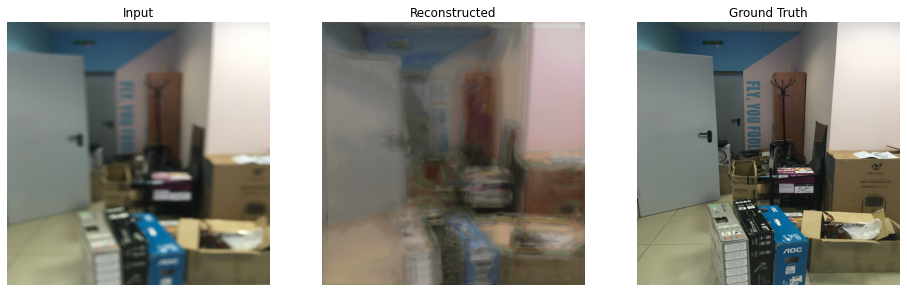

In [31]:
#@title Probando el modelo con la misma imagen después de entrenar el modelo
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = no_transfer_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

## **Modelo del estado del arte: Xception modificado**

Como última prueba, tomaremos una red neuronal de estado del arte, en este caso la Xception desarrollada por Google, ya que se encuentra preentrenada con el dataset imagenet, que cuenta con más de 14 millones de imagenes, como este modelo fue desarrollado para la clasificación de imagenes lo que se hizo fue removerle las últimas capas (estas son las capas que realizan clasificación), y añadir el decoder de nuestro modelo propuesto.


<center><img src="https://i.ibb.co/s96WB2Z/U-Xception.png"></center>

**Fuente:** https://arxiv.org/abs/1610.02357

El modelo consta de tres bloques de flujo principal todos van en cascada de izquierda a derecha, estos bloques son sencillamente una abstracción operaciones convolucionales separables en profundidad, estas operaciones permite extraer muchas más caracteristicas de una imagen de entrada que una red común, por lo que posee también muchisimas capas convolucionales que repiten el proceso a medida que se va avanzando la imagen, el final de la red, como se observa, se removieron las dos últimas capas y se añadió el decoder usado en el modelo propuesto para reconstruir la imagen. También es importante resaltar que las dimensiones espaciales de la imagen de entrada se adaptará al dataset que tenemos que ese de $512 \times 512 \times 3$.


In [32]:
Xception_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(512, 512, 3),
    include_top=False) 

83689472/83683744 [==============================] - 1s 0us/step


In [33]:
#@title Congelando todo el modelo
Xception_model.trainable = False
Xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [34]:
#@title Añadiendo capas para la reconstrucción
inputs = keras.Input(shape=(512, 512, 3))
x = Xception_model(inputs, training=False)

bandas = 3

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(x)
c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c6)
c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c7)
c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c8)
c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(8, 2, strides=(2, 2), padding='same')(c9)
c10 = tf.keras.layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c10)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(c10)

Xception_TF_model = keras.Model(inputs, outputs, name='Xception_TF')
Xception_TF_model.summary()

Model: "Xception_TF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 128)       1048704   
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 64)        

In [35]:
Xception_TF_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=False),
                          loss='mean_squared_error',
                          metrics=['accuracy', psnr])

PSNR obtenido: tf.Tensor([12.855897], shape=(1,), dtype=float32)


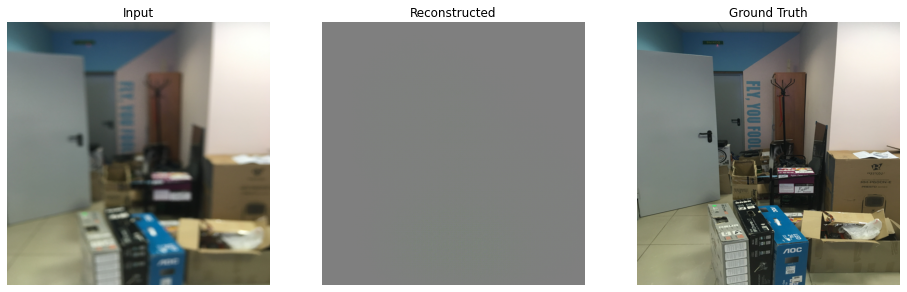

In [36]:
#@title Reconstruyendo imagen con pesos aleatorios
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = Xception_TF_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

In [37]:
#@title Checkpoint
checkpoint_dir = "Check_points_TL_Xception"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=Xception_TF_model)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title Guardar modelo
# checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
#@title Entrenando el modelo
TOTAL_EPOCHS = 100
SAVE_EPOCHS = 20
PSNR_grap = []
LOSS_grap = []
accuracy_grap = []
for i in range(int(TOTAL_EPOCHS/SAVE_EPOCHS)):
  print("Iteración {}".format(i + 1))
  history = Xception_TF_model.fit(blur_train_dataset, epochs=SAVE_EPOCHS,verbose=1)
  PSNR_grap.append(history.history['psnr'])
  LOSS_grap.append(history.history['loss'])
  accuracy_grap.append(history.history['accuracy'])
  checkpoint.save(file_prefix=checkpoint_prefix)
  np.save(checkpoint_dir+"/PSNR.npy", PSNR_grap)
  np.save(checkpoint_dir+"/LOSS.npy", LOSS_grap)
  np.save(checkpoint_dir+"/ACCU.npy", accuracy_grap)

Iteración 1
Epoch 1/20
280/280 [==============================] - 581s 2s/step - loss: 0.0713 - accuracy: 0.5665 - psnr: 11.8527
Epoch 2/20
280/280 [==============================] - 83s 296ms/step - loss: 0.0686 - accuracy: 0.6016 - psnr: 12.0068
Epoch 3/20
280/280 [==============================] - 82s 295ms/step - loss: 0.0662 - accuracy: 0.5960 - psnr: 12.1390
Epoch 4/20
280/280 [==============================] - 83s 296ms/step - loss: 0.0606 - accuracy: 0.5895 - psnr: 12.5018
Epoch 5/20
280/280 [==============================] - 82s 293ms/step - loss: 0.0560 - accuracy: 0.5981 - psnr: 12.8421
Epoch 6/20
280/280 [==============================] - 81s 291ms/step - loss: 0.0528 - accuracy: 0.6058 - psnr: 13.0824
Epoch 7/20
280/280 [==============================] - 81s 289ms/step - loss: 0.0507 - accuracy: 0.6072 - psnr: 13.2576
Epoch 8/20
280/280 [==============================] - 81s 290ms/step - loss: 0.0478 - accuracy: 0.6037 - psnr: 13.5132
Epoch 9/20
280/280 [==================

PSNR obtenido: tf.Tensor([17.42789], shape=(1,), dtype=float32)


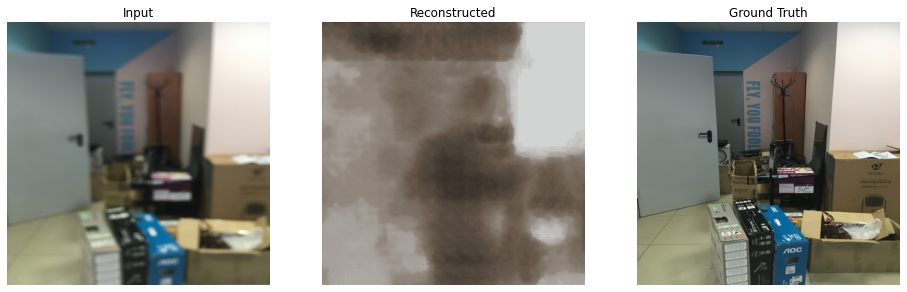

In [38]:
#@title Probando el modelo con la misma imagen después de entrenar el modelo
image_path = blur_dataset[0,:]
inp, tar = load_image(image_path)
reconstructed = Xception_TF_model(inp[tf.newaxis,...], training=False)
plot_image_pair_reconstructed(inp, reconstructed[0,...], tar)

# **Resultados obtenidos**

En esta sección:

* Se mostrará los resultados obtenidos realizando las reconstrucciones de los pares de imagenes de prueba del Blur Dataset y mostraremos la calidad de reconstrucción en terminos del PSNR ya que es la que permite obtener una representación númerica de la calidad de la reconstrucción de imagenes respecto a su imagen objetivo.

* Se mostrará el historial de entrenamiento de cada uno de los modelos entrenados con las tres distintas metricas PNSR, MSE y accuracy.

* Se visualizará algunas de las imagenes de prueba comparandose entre si con cada uno de los modelos entrenados.

In [ ]:
#@title Función que calcula los psnr de un dataset dado su modelo
def load_psnr_model(model, dataset):

  PSNR = []
  for i, (test_input, test_output) in enumerate(dataset.take(70)):
    reconstructed = model(test_input, training=False)
    PSNR.append(psnr(test_output, reconstructed))
  
  return PSNR

In [ ]:
#@title Calculando todos los PNSR del Blur Test Dataset para cada uno de los modelos desarrollados
PSNR_transfer_model_half = load_psnr_model(transfer_model, blur_test_dataset)
PSNR_transfer_model_no_freezing = load_psnr_model(transfer_model_no_freezing, blur_test_dataset)
PSNR_no_transfer_learning = load_psnr_model(no_transfer_model, blur_test_dataset)
PSNR_Xception_model = load_psnr_model(Xception_TF_model, blur_test_dataset)

In [ ]:
#@title Mostrando cada uno de los PSNR del Blur Test Dataset para cada uno de los modelos
PSNR_total = pd.DataFrame({'Propuesto': np.array([psnr.numpy() for psnr in PSNR_transfer_model_half]).squeeze(),
                           'Sin congelar': np.array([psnr.numpy() for psnr in PSNR_transfer_model_no_freezing]).squeeze(),
                           'Sin TF': np.array([psnr.numpy() for psnr in PSNR_no_transfer_learning]).squeeze(),
                           'Xception modificado': np.array([psnr.numpy() for psnr in PSNR_Xception_model]).squeeze()})

pd.set_option("display.max_rows", None, "display.max_columns", None)
print('TF es transferencia de aprendizaje.')
PSNR_total

TF es transferencia de aprendizaje.


Propuesto  Sin congelar     Sin TF  Xception modificado
0   10.032451     10.208048  10.181034            10.972605
1   10.083113     10.286344  10.062700             9.778749
2   13.712953     14.196185  14.634723            14.012718
3   14.821824     15.453729  14.805344            12.901582
4   15.619877     14.771181  16.022226            12.256557
5   18.003069     17.571669  17.784142            14.756302
6   18.642427     18.372841  12.313492            10.771603
7   15.076822     15.293204  15.097184            14.688358
8   12.350945     12.284992  12.412717            10.513556
9   14.605475     14.205365  14.362395             9.278688
10  10.933591     11.120956  11.034169            10.312092
11  13.434094     13.845531  13.656592            11.864820
12  11.100743     11.410649  11.102475            11.536567
13  11.150293     11.518831  11.240749            10.756157
14  12.433846     12.748160  12.658453            11.579463
15  12.669714     12.995432  12.989959            10.992710
16  17.583416     17.341417  17.254999            13.524872
17  14.786162     13.927634  14.290509            11.138788
18  15.418456     15.281253  15.151187            11.673659
19   8.758379      8.826537   8.919867            11.009463
20  11.934628     12.524644  12.125766            12.072479
21  13.176960     14.095713  13.425529            13.368714
22  13.785105     13.956449  13.871897            12.357477
23  16.064678     16.268169  16.597757            13.021807
24  12.214066     11.968493  12.170973            10.545236
25  15.354771     14.985678  15.245522            14.135487
26  12.162283     12.374528  11.745882             9.919995
27  16.154383     17.363733  16.830925            13.812232
28  15.973983     16.060928  15.823657            11.411113
29  12.977596     12.031429  13.002324             9.270189
30  19.757008     17.972906  19.907627            13.201430
31  15.132401     14.531075  13.954743            11.271132
32  15.417263     15.971087  15.966462            13.369030
33  14.102654     14.652708  14.448386            12.513776
34  12.074022     12.359330  12.396741            11.264297
35  13.600793     13.893914  13.703972            12.564924
36  14.006072     14.403328  14.190748            12.900016
37  14.535687     14.888774  14.723783            11.869472
38   9.862625      9.748039   9.618896             8.950579
39  13.662886     13.478679  13.860067            11.253815
40  13.772494     13.698544  13.918726            13.185087
41  15.043497     14.796355  15.614191            12.699036
42  12.858921     13.048434  13.211256            12.333616
43  15.756178     16.699783  16.574396            10.368388
44  11.963372     12.231752  12.153869            11.901533
45  14.109240     14.418133  11.658271            11.055348
46  13.790841     13.877165  13.830975            12.007364
47  13.743402     13.166469  13.708854            10.959688
48  13.517181     13.637923  13.708971            11.701690
49  11.852935     12.391451  11.865191            10.322857
50  13.008801     12.841957  13.306662            10.904306
51  13.078055     13.105971  13.139614            13.163370
52  19.787668     21.049419  20.203077            13.997029
53  14.475191     14.127352  14.872144            13.365677
54  17.665970     17.383944  17.787521            12.881971
55   7.462991      7.589792   7.464260            10.041245
56  11.962997     12.156033  12.058515            12.360561
57   8.574774      8.644759   8.729849             8.418375
58  14.865839     15.252397  14.917349            11.903163
59  17.066767     16.502060  16.749010            12.154151
60  13.376665     13.484469  13.424839            12.296958
61  19.477453     19.634047  19.693764            13.786116
62  14.712851     13.252680  14.449948             9.687248
63  17.334528     16.862921  17.401217            10.572803
64  16.718287     16.448427  16.698021            12.060740
65  16.894611     17.169903  17.406828      

In [ ]:
#@title Resumen en la calidad de reconstrucción basada en la métrica PSNR del Test Blur Dataset
PSNR_total.describe()

TF_half  TF_no_freezing      NO_TF  TF_Xception
count  70.000000       70.000000  70.000000    70.000000
mean   14.107340       14.127115  14.085491    11.793797
std     2.581096        2.524316   2.581738     1.440310
min     7.462991        7.589792   7.464260     8.418375
25%    12.492813       12.508280  12.400735    10.804779
50%    13.966845       14.026081  13.895311    11.867146
75%    15.418158       15.418882  15.522024    12.901190
max    19.787668       21.049419  20.203077    14.756302

In [39]:
#@title cargando todos los PNSR de los entrenamientos de los modelos
checkpoint_dir = "Check_points_Transfer_Learning_Blur_36_1"
_psnr_transfer_model_half = np.load(checkpoint_dir + '/PSNR.npy').reshape((-1,1)).squeeze()
_loss_transfer_model_half = np.load(checkpoint_dir + '/LOSS.npy').reshape((-1,1)).squeeze()
_accu_transfer_model_half = np.load(checkpoint_dir + '/ACCU.npy').reshape((-1,1)).squeeze()

checkpoint_dir = "Check_points_Transfer_Learning_NO_Freezing"
_psnr_transfer_model_no_freezing = np.load(checkpoint_dir + '/PSNR.npy').reshape((-1,1)).squeeze()
_loss_transfer_model_no_freezing = np.load(checkpoint_dir + '/LOSS.npy').reshape((-1,1)).squeeze()
_accu_transfer_model_no_freezing = np.load(checkpoint_dir + '/ACCU.npy').reshape((-1,1)).squeeze()

checkpoint_dir = "Check_points_NO_Transfer_Learning_Blur"
_psnr_no_transfer_learning = np.load(checkpoint_dir + '/PSNR.npy').reshape((-1,1)).squeeze()
_loss_no_transfer_learning = np.load(checkpoint_dir + '/LOSS.npy').reshape((-1,1)).squeeze()
_accu_no_transfer_learning = np.load(checkpoint_dir + '/ACCU.npy').reshape((-1,1)).squeeze()

checkpoint_dir = "Check_points_TL_Xception"
_psnr_Xception_TF = np.load(checkpoint_dir + '/PSNR.npy').reshape((-1,1)).squeeze()
_loss_Xception_TF = np.load(checkpoint_dir + '/LOSS.npy').reshape((-1,1)).squeeze()
_accu_Xception_TF = np.load(checkpoint_dir + '/ACCU.npy').reshape((-1,1)).squeeze()

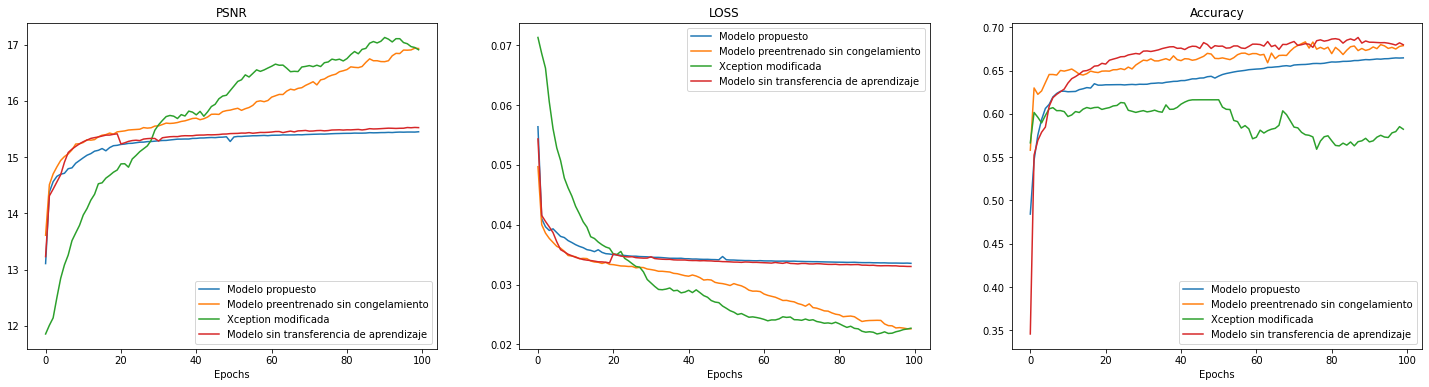

In [40]:
#@title Comparando calidad de entrenamiento de cada modelo
metrics = {'PSNR' : [_psnr_transfer_model_half, _psnr_transfer_model_no_freezing, _psnr_Xception_TF, _psnr_no_transfer_learning],
           'LOSS' : [_loss_transfer_model_half, _loss_transfer_model_no_freezing, _loss_Xception_TF, _loss_no_transfer_learning],
           'Accuracy' : [_accu_transfer_model_half, _accu_transfer_model_no_freezing, _accu_Xception_TF, _accu_no_transfer_learning]}
names = ['Modelo propuesto', 'Modelo preentrenado sin congelamiento', 'Xception modificada', 'Modelo sin transferencia de aprendizaje']

epochs = range(100)


plt.figure(figsize=(25,6))

for i, key in enumerate(metrics):
  plt.subplot(1,len(metrics), i + 1)
  for j, met in enumerate(metrics[key]):
    plt.plot(epochs, met, label=key)
    plt.title(key)
    plt.xlabel("Epochs")
  
  plt.legend(names);


In [41]:
#@title Graficando la reconstrucción de las imagenes de prueba
def plot_results(models, test_dataset, n_images):
  row = len(models) + 2
  names = ['Input', 'TF half', 'TF no freezing', 'TF Xception', 'NO TF', 'Target']

  plt.figure(figsize=(26, 22))
  for k, model in enumerate(models):
    for i, (test_input, test_output) in enumerate(test_dataset.take(n_images)):
      if k == 0:
        plt.subplot(row, n_images, (k * n_images) + (i + 1))
        plt.imshow(test_input[0,...])
        if i == 0:
          plt.ylabel(names[0], fontsize=23)
      elif k == row - 3:
        plt.subplot(row, n_images, ((k + 2) * n_images) + (i + 1))
        plt.imshow(test_output[0,...])
        if i == 0:
          plt.ylabel(names[5], fontsize=23)
      
      plt.xticks([])
      plt.yticks([])
      #plt.axis('off')
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)
      plt.gca().spines['left'].set_visible(False)


      plt.subplot(row, n_images, ((k + 1) * n_images) + (i + 1))
      reconstructed = model(test_output, training=False)
      plt.imshow(reconstructed[0,...])

      if i == 0:
        plt.ylabel(names[k+1], fontsize=23)

      plt.xticks([])
      plt.yticks([])
      #plt.axis('off')
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)
      plt.gca().spines['left'].set_visible(False)

  plt.savefig('resultados.png', bbox_inches='tight', pad_inches=0)

In [42]:
#@title Visualizando la calidad de reconstrucción de cada uno de los modelos entrenamos
models =[transfer_model, transfer_model_no_freezing, Xception_TF_model, no_transfer_model]
plot_results(models, blur_test_dataset, 7)

Output hidden; open in https://colab.research.google.com to view.

# **Conclusiones**

**Importante:** cabe resaltar que cualquier tipo de red neuronal convolucional depende de muchos aspectos para obtener optimos resultados, en este caso, la calidad y coherencia del dataset, y como se mencionó inicialmente, el dataset usado no fue creado originalmente para resolver este tipo de problemas, por lo que para cada par de imagenes los pixeles no coinciden, por lo que la correlacción entre una imagen de entrada y su imagen de salida es altamente escasa, teniendo en cuenta esto, pasamos a mencionar los resultados obtenidos.

La tabla de resultados muestra los resultados obtenidos en PSNR reconstruyendo las imagenes de prueba, respecto a la media del PSNR obtenida, el orden de calidad de reconstrucción viene dado por:
  
1. El modelo preentrenado sin aplicar ajuste fino o congelamiento de capas, sin embargo, observamos que la calidad visual de la reconstrucción no fue buena ya que al no congelar de nuevo las capas el entrenamiento que se le realizo tendio al sobreajuste del modelo, al igual que el modelo sin transferencia de aprendizaje.

2. Nuestro modelo propuesto, donde se congelo la mitad del modelo preentrenado, a pesar de no obtener el primer lugar, observamos que la capacidad de generalización del modelo para interpretar las imagenes y evitar el sobreajuste fue la que mejor funcionó en todos los modelos presentados.

3. El modelo sin transferencia de aprendizaje, este modelo le iba a ocurrir algo similar al modelo preentrenado sin aplicar ajuste fino ya que la única diferencia entre estos dos modelos es que inicializan con pesos distintos, por lo que también podemos apreciar la similitud en la reconstrucción.

4. La red Xception modificada, consideramos su pesimo rendimiento debido a que su implementación interna otro tipo de capas convolucionales a las que se se le adaptaron al final para intentar no romper el esquema de trabajar bajo el mismo sistema de arquitectura propuesta, por los pesos durante su entrenamiento habrán convergido erradamente tratandose de un problema de optimización convexo, al igual que los demás.

Respecto a las gráficas de convergencias durante el entrenamiento de los modelos concluimos que:

*  El modelo propuesto y el modelo sin transferencia de aprendizaje obtuvieron un comportamiento similar en las tres métricas evaluadas.
*  El modelo preentrenado sin congelamiento de capas y la Xception tuvieron un comportamiento similar y más alto que los mencionados anteriormente. Sin embargo, la calidad visual de la reconstrucción es peor que el modelo propuesto.

**Motivación final:** este trabajo es un marco de referencia que busca reflejar que la importancia de las diferentes técnicas para mejorar la reconstrucción de redes neuronales (en este caso aplicando transferencia de aprendizaje) puede proveer resultados interesantes e incluso buenos que aún no han sido explotados como es debido, y este proyecto es un claro ejemplo de ello, por lo que este campo de investigación aún tiene mucho que aportar a la sociedad y a la fotografía.
